## Importations des bibliotheques 

In [1]:
import pandas as pd
import re
import requests
import lxml.html as lh
import pandas as pd
import csv
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


## Scrapping 

In [2]:

url = 'http://www.allocine.fr/film/fichefilm-143692/critiques/spectateurs/' #
uri_pages = '?page='
nbPages = 100
tags = ['//span[@class="stareval-note"]', '//div[@class="content-txt review-card-content"]']
cols = ['Note', 'Description']

def getPage(url):
    page = requests.get(url)
    doc = lh.fromstring(page.content)
    
    content = []
    for i in range(len(tags)):
        content.append(doc.xpath(tags[i]))
    
    df_liste = []
    for j in range(len(tags)):
        tmp = pd.DataFrame([content[j][i].text_content().strip() for i in range(len(content[j]))], columns=[cols[j]])
        tmp['key'] = tmp.index
        df_liste.append(tmp)
    
    liste = df_liste[0]
    for j in range(len(tags)-1):
        liste = liste.join(df_liste[j+1], on='key', how='left', lsuffix='_l', rsuffix='_r')
        liste['key'] = liste.index
    del liste['key_l']
    del liste['key_r']
    return liste

def getPages(_nbPages, _url):
    liste_finale = pd.DataFrame()
    for i in range (_nbPages):
        liste = getPage(_url + uri_pages + str(i+1))
        liste_finale = pd.concat([liste_finale, liste], ignore_index=True)
    return liste_finale

liste_totale = getPages(nbPages, url)
liste_totale.to_csv('allocine_inception_avis.csv', index=False, sep=',', encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)


## Chargement des données

In [3]:
df = pd.read_csv('allocine_inception_avis.csv')
df.head(100)


,Note,Description,key
0,"5,0",Après le chef d'oeuvre super-héroïque The Dark...,0
1,"5,0",C’est fou ce qu’on aime détester Christopher N...,1
2,"5,0",CHEF D’ŒUVRE ! Le film est absolument parfait ...,2
3,"5,0","Un film aussi novateur que complexe, dont la m...",3
4,"5,0",Nolan est un vrai génie. On l'avait déjà entra...,4
...,...,...,...
95,"5,0",Inception : Un film d’exception que je qualifi...,11
96,"4,0",Sacré film bien sûr. Nolan pourrait faire comm...,12
97,"5,0","Après les 2 superbes batman, je me disait bien...",13
98,"1,0",Tellement tordu et absurde qu'il en devient én...,14


## Pré-traitement

In [4]:
df.shape

(2100, 3)

In [5]:
df.isnull().sum()

Note             0
Description    600
key              0
dtype: int64

In [6]:
df.shape

(2100, 3)

In [7]:
## Supression des valeurs manquantes
df1=df.copy()
df1.dropna(inplace=True)
df1.isnull().sum()

Note           0
Description    0
key            0
dtype: int64

In [8]:
df1.shape

(1500, 3)

In [9]:
# Vérifier les doublons
doublons = df1.duplicated()

# Afficher les lignes qui sont des doublons
print(df1[doublons])

Empty DataFrame
Columns: [Note, Description, key]
Index: []


In [10]:
## Suppression des doublons 
df1.drop_duplicates(inplace=True)

In [11]:
#Suppression de la colonne key
# Supprimer la colonne "key"
df1.drop(columns=['key'], inplace=True)

In [12]:
df1.shape

(1500, 2)

In [13]:
# Prétraitement de données
import re
import nltk
import contractions
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def clean_text(text):
    # Supprimer les en-têtes (texte situé en haut du document)
    text = re.sub(r'^.*\n', '', text)

    # Supprimer les pieds de page (texte situé en bas du document)
    text = re.sub(r'\n.*$', '', text)

    # Supprimer les citations (texte entre guillemets)
    text = re.sub(r'".*?"', '', text)

    # Supprimer les caractères spéciaux (sauf espaces)
    text = re.sub(r"[^\w\s]", "", text)

    # Utiliser une expression régulière pour supprimer les chiffres
    text = re.sub(r'\d', '', text)

    # Convertir en minuscules
    text = text.lower()

    # Contractions
    text = contractions.fix(text)

    # Tokenization
    words = nltk.word_tokenize(text)

    # Liste de stopwords personnalisable (remplacer par vos stopwords)
    stopwords = nltk.corpus.stopwords.words('english')

    # Supprimer les stopwords
    words = [word for word in words if word not in stopwords]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in words]

    # Filtrage des mots trop courts ou non pertinents
    lemmatized_tokens = [word for word in lemmatized_tokens if len(word) > 2]
    
    # Rejoindre les tokens en une seule chaîne de texte
    text = " ".join(lemmatized_tokens)

    return text


# Nettoyage et stockage des commentaires dans la liste comments_pre
comments_pre = []
for comment in df1['Description']:
    cleaned_text = clean_text(comment)
    comments_pre.append(cleaned_text)

# Ajout de la liste des commentaires nettoyés comme nouvelle colonne dans le DataFrame
df1['clean_description'] = comments_pre
comments_pre

['après chef doeuvre superhéroïque dark knight christopher nolan carte blanche pour réaliser son prochain longmétrage met alors réalisation dun film coécrit avec son frère qui pour nom récit mélange réalité rêve spectateur méprend alors puis apprend discerner vrai faux trouver clés scénarioinception est chef doeuvre véritable chef doeuvre christopher nolan illustre son talent par réalisation son scénario intelligence pure dernier révèle complexe première vue puis long visionnage lon rend peu peu compte force puissance émotionnelle capacité brouiller piste cellesci sont également éparpillées grâce une mise scène incroyable osant grandiose lintime inception peut savérer être blockbuster ultravisuel mais également drame prenant puisque lintrigue principale est finalement deuilpour parfaire cette grande production nolan recourt casting prestigieux tête daffiche leonardo dicaprio dans rôle fort lacteur trouve être loin hauteur puisquil insuffle beaucoup charisme sentiment son personnage nou

In [14]:
# Définir la fonction setClassBin
def setClassBin(i):
    if (float(str(i).replace(',', '.')) > 3):
        return 1
    else:
        return 0 

# Appliquer la fonction setClassBin à la colonne 'Note' pour créer la colonne cible 'target'
df1['target'] = df1['Note'].apply(setClassBin)

# Afficher les premières lignes du DataFrame pour vérifier les changements
df1.head(10)

,Note,Description,clean_description,target
0,"5,0",Après le chef d'oeuvre super-héroïque The Dark...,après chef doeuvre superhéroïque dark knight c...,1
1,"5,0",C’est fou ce qu’on aime détester Christopher N...,spoiler moi cette histoire subconscient qui sa...,1
2,"5,0",CHEF D’ŒUVRE ! Le film est absolument parfait ...,chef dœuvre film est absolument parfait acteur...,1
3,"5,0","Un film aussi novateur que complexe, dont la m...",film aussi novateur que complexe mise scène to...,1
4,"5,0",Nolan est un vrai génie. On l'avait déjà entra...,nolan est vrai génie lavait déjà entraperçyou ...,1
5,"5,0",Christopher Nolan est sûrement l'un des seuls ...,spoiler soldats tirent tout croche vient fait ...,1
6,"3,5",Le meilleur blockbuster de 2010 a pour thème l...,meilleur blockbuster pour thème délicate diffe...,1
7,"4,0",""" inception "" Un film de science fiction très ...",spoiler rêves emboîter dans rêves projection q...,1
8,"5,0","Dans la catégorie des blockbusters, on a rarem...",dans catégorie blockbuster rarement mieux mise...,1
9,"5,0",Un film époustouflant(un de mes préférés) ! Le...,film époustouflantun préférés scénario est int...,1


In [16]:
# Sélectionner aléatoirement 10 000 tweets positifs
reviews_positifs = df1[df1['target'] == 1].sample(n=300, random_state=42)

# Sélectionner aléatoirement 10 000 tweets négatifs
reviews_negatifs = df1[df1['target'] == 0].sample(n=300, random_state=42)

# Concaténer les tweets positifs et négatifs sélectionnés
df_select = pd.concat([reviews_positifs, reviews_negatifs])

# Réinitialiser les index
df_select = df_select.reset_index(drop=True)
df_select

,Note,Description,clean_description,target
0,"5,0",Excellent film. J avais des préjugé et en fait...,excellent film avais préjugé faite est long me...,1
1,"4,0","Ce ""Mission Impossible"" des rêves vaut surtout...",rêves vaut surtout par qualité jeu acteurs par...,1
2,"5,0","Ce voyage onirique aurait pu être abscons, mai...",voyage onirique aurait être abscons mais que n...,1
3,"5,0","Super film, malgré une fin un peu confuse, et ...",super film malgré une fin peu confuse tres coé...,1
4,"5,0",je n'ai jamais vue un films aussi splendide de...,nai jamais vue film aussi splendide vie cest v...,1
...,...,...,...,...
595,"3,0",Encore un film avec Dicaprio que j'adore (a pa...,encore film avec dicaprio que jadore part tita...,0
596,"3,0","Comme tous les Nolan : travaillé, riche, soign...",comme tous nolan travaillé riche soigné sombre...,0
597,"3,0",Des acteurs au top... rien à dire...des effets...,acteurs top rien diredes effets spéciaux topun...,0
598,"1,0","Je poste après que mon beauf m'ait tané : ""Oua...",poste après que mon beauf mait tané car suis e...,0


In [27]:
df_select['target'].value_counts()

target
1    300
0    300
Name: count, dtype: int64

## Proportion des commentaires en fonction de target(0,1)

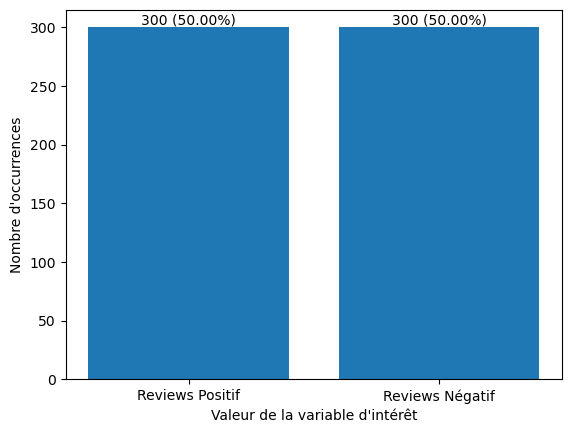

In [18]:
target_counts = df_select['target'].value_counts()

# Calculer la proportion pour chaque valeur de la variable d'intérêt (target)
target_proportions = df_select['target'].value_counts(normalize=True)

# Créer un graphique à barres pour visualiser la distribution
plt.bar(target_counts.index, target_counts.values)

# Ajouter les étiquettes des barres (nombre d'occurrences et proportion)
for i, count in enumerate(target_counts):
    proportion = target_proportions[i]
    plt.text(i, count, f"{count} ({proportion:.2%})", ha='center', va='bottom')

# Étiqueter l'axe des x et y
plt.xlabel('Valeur de la variable d\'intérêt')
plt.ylabel('Nombre d\'occurrences')

# Ajouter une légende aux barres
plt.xticks(target_counts.index, ['Reviews Négatif', 'Reviews Positif'])

# Afficher le graphique
plt.show()

## Generer le word cloud 

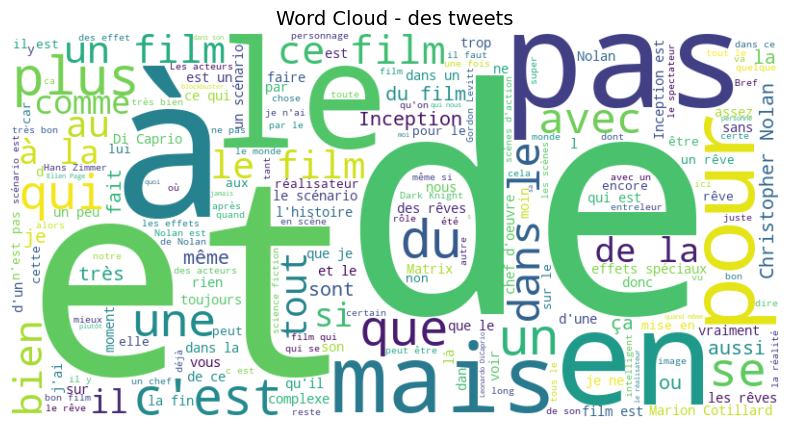

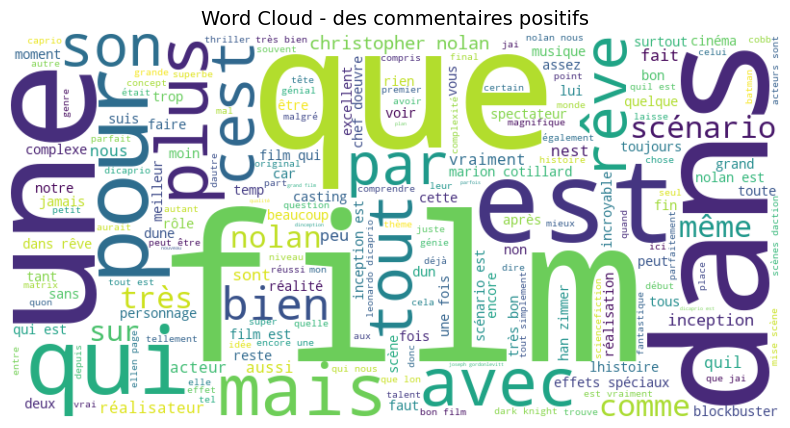

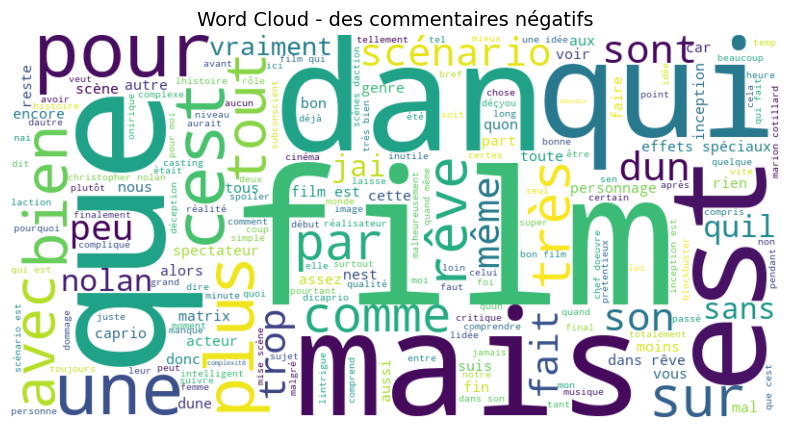

In [42]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Fonction pour générer le word cloud
def generer_wordcloud(tweets, titre):
    tout_texte = ' '.join(tweets)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tout_texte)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(titre, fontsize=14)
    plt.axis('off')
    plt.show()

# Générer le word cloud pour chaque type de sentiment
generer_wordcloud(df_select['Description'], 'Word Cloud - des tweets')
generer_wordcloud(reviews_positifs['clean_description'], 'Word Cloud - des commentaires positifs')
generer_wordcloud(reviews_negatifs['clean_description'], 'Word Cloud - des commentaires négatifs')

## Vectorisation du texte

### Implementation du BOW

In [92]:
vectorizer_bow = CountVectorizer()
vectorizer_bow.fit(df_select['clean_description'])  # Adapter le vectoriseur aux données
X_bow = vectorizer_bow.transform(df_select['clean_description'])  # Transformer les données en vecteurs BoW

## Création du DataFrame
df_bow = pd.DataFrame(X_bow.toarray(), columns=vectorizer_bow.get_feature_names_out())
## Affichage du DataFrame
print("Bag of Words (BoW) :\n")
df_bow

Bag of Words (BoW) :



,abandonné,abattage,abime,abonnés,abord,abordable,aborde,abordé,abouti,aboutir,...,évoque,évoquer,évoqué,évènements,événements,êtes,être,êtres,œil,œuvre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
596,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
598,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Implementation de N-grammes

In [44]:
## N-grammes
vectorizer_ngram = CountVectorizer(ngram_range=(2, 2))
X_ngram = vectorizer_ngram.fit_transform(df_select['clean_description'])
df_ngram = pd.DataFrame(X_ngram.toarray(), columns=vectorizer_ngram.get_feature_names_out())
print("\nN-grammes :\n")
df_ngram



N-grammes :



,abandonné contrat,abandonné suis,abattage habituel,abime quelque,abonnés absents,abord complexe,abord dautant,abord faut,abordable chose,abordable est,...,œuvre colossale,œuvre complexe,œuvre froide,œuvre géniale,œuvre hors,œuvre mais,œuvre malgré,œuvre mérite,œuvre unanimement,œuvre était
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
596,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
598,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Implementation de TF-IDF

In [93]:
## TF-IDF
vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(df_select['clean_description'])
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer_tfidf.get_feature_names_out())
## Add the cluster labels as a new column to your DataFrame (optional)
## Get cluster labels for each document
print("\nTF-IDF :\n")
df_tfidf


TF-IDF :



,abandonné,abattage,abime,abonnés,abord,abordable,aborde,abordé,abouti,aboutir,...,évoque,évoquer,évoqué,évènements,événements,êtes,être,êtres,œil,œuvre
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.095252,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.126178,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.085417,0.0,0.0,0.0
596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


### Clustering

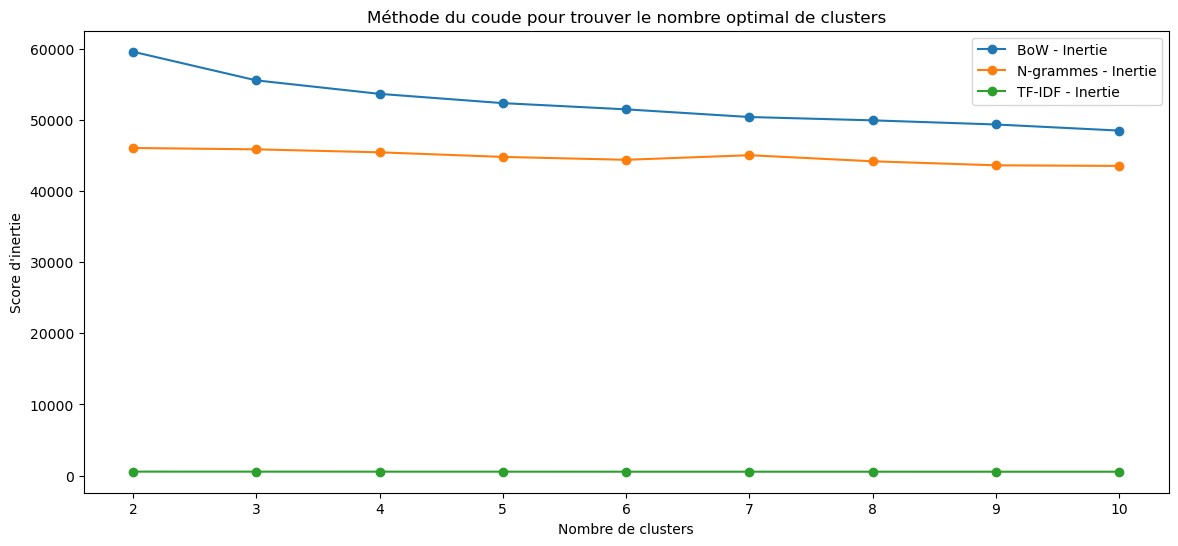

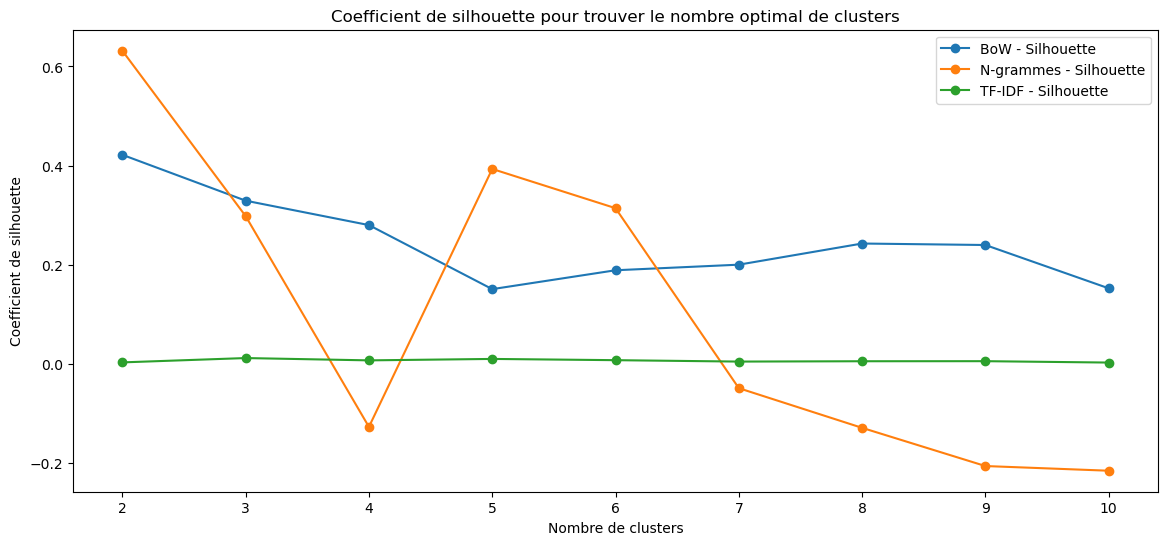

In [94]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Définir une liste de vecteurs et noms correspondants
vecteurs = [X_bow, X_ngram, X_tfidf]
noms_vecteurs = ['BoW', 'N-grammes', 'TF-IDF']

# Initialiser des listes pour stocker les scores d'inertie et de silhouette pour chaque méthode
inertia_scores_all = []
silhouette_scores_all = []

# Calculer le score d'inertie et de silhouette pour chaque méthode
for X, nom_vecteur in zip(vecteurs, noms_vecteurs):
    inertia_scores, silhouette_scores = [], []
    nombre_clusters = range(2, 11)  # Commencer à partir de 2 clusters
    for k in nombre_clusters:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertia_scores.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    inertia_scores_all.append((nom_vecteur, inertia_scores))
    silhouette_scores_all.append((nom_vecteur, silhouette_scores))

# Tracer les graphiques
plt.figure(figsize=(14, 6))

# Graphique d'inertie
for nom_vecteur, inertia_scores in inertia_scores_all:
    plt.plot(nombre_clusters, inertia_scores, marker='o', label=f'{nom_vecteur} - Inertie')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score d\'inertie')
plt.title('Méthode du coude pour trouver le nombre optimal de clusters')
plt.legend()

# Graphique de silhouette
plt.figure(figsize=(14, 6))
for nom_vecteur, silhouette_scores in silhouette_scores_all:
    plt.plot(nombre_clusters, silhouette_scores, marker='o', label=f'{nom_vecteur} - Silhouette')
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de silhouette')
plt.title('Coefficient de silhouette pour trouver le nombre optimal de clusters')
plt.legend()

plt.show()

# KMEANS

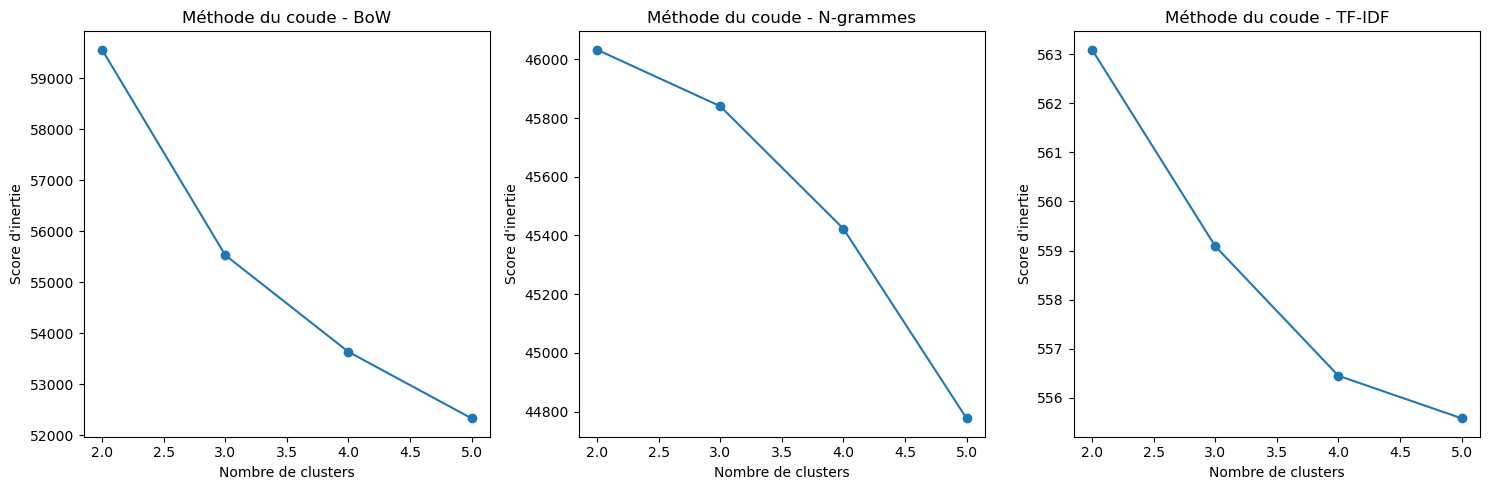

In [95]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Définir une liste de nombres de clusters à tester
nombre_clusters = [2, 3, 4, 5] 

# Initialiser des listes pour stocker les scores d'inertie pour chaque méthode
inertia_scores_all = []

# Calculer le score d'inertie pour chaque nombre de clusters pour chaque méthode
for X, nom_vecteur in zip([X_bow, X_ngram, X_tfidf], ['BoW', 'N-grammes', 'TF-IDF']):
    inertia_scores = []
    for k in nombre_clusters:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertia_scores.append(kmeans.inertia_)
    inertia_scores_all.append((nom_vecteur, inertia_scores))

# Tracer les graphiques
plt.figure(figsize=(15, 5))

for i, (nom_vecteur, inertia_scores) in enumerate(inertia_scores_all, 1):
    plt.subplot(1, 3, i)
    plt.plot(nombre_clusters, inertia_scores, marker='o')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Score d\'inertie')
    plt.title(f'Méthode du coude - {nom_vecteur}')

plt.tight_layout()
plt.show()


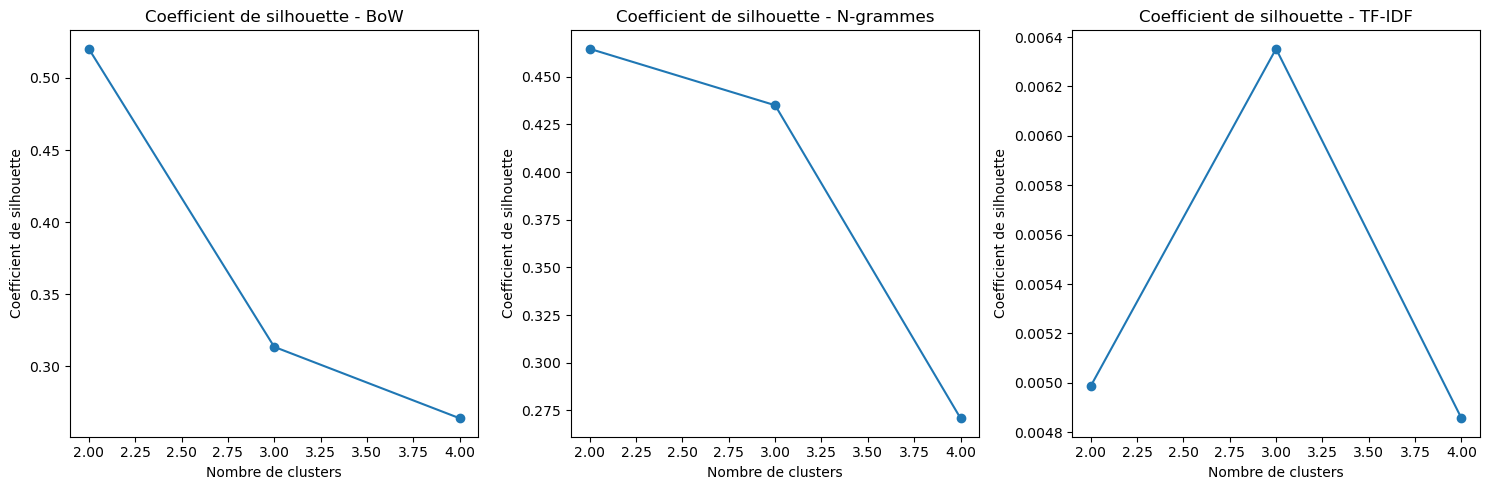

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Définir une liste de nombres de clusters à tester
nombre_clusters = range(2, 5)  # Commence à 2 pour le coefficient de silhouette

# Initialiser des listes pour stocker les scores de silhouette pour chaque méthode
silhouette_scores_all = []

# Calculer le score de silhouette pour chaque nombre de clusters pour chaque méthode
for X, nom_vecteur in zip([X_bow, X_ngram, X_tfidf], ['BoW', 'N-grammes', 'TF-IDF']):
    silhouette_scores = []
    for k in nombre_clusters:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, labels))
       
    silhouette_scores_all.append((nom_vecteur, silhouette_scores))

# Tracer les graphiques
plt.figure(figsize=(15, 5))

for i, (nom_vecteur, silhouette_scores) in enumerate(silhouette_scores_all, 1):
    plt.subplot(1, 3, i)
    plt.plot(nombre_clusters, silhouette_scores, marker='o')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Coefficient de silhouette')
    plt.title(f'Coefficient de silhouette - {nom_vecteur}')

plt.tight_layout()
plt.show()


In [96]:
from sklearn.metrics import silhouette_score
kmeans_bow = KMeans(n_clusters=2,random_state=42,n_init=10)
kmeans_bow.fit(X_bow)
silhouette_score_bow = silhouette_score(X_bow, kmeans_bow.labels_)
print("Resultat avec la methode du BOW:", silhouette_score_bow)

Resultat avec la methode du BOW: 0.42176158924164


In [97]:
from sklearn.metrics import silhouette_score
kmeans_bow = KMeans(n_clusters=2,random_state=42, n_init=10)
kmeans_bow.fit(X_ngram)
silhouette_score_ = silhouette_score(X_ngram, kmeans_bow.labels_)
print("Silhouette Coefficient:", silhouette_score_)

Silhouette Coefficient: 0.6317998264956922


In [98]:
from sklearn.metrics import silhouette_score
kmeans_bow = KMeans(n_clusters=2,random_state=42, n_init=10)
kmeans_bow.fit(X_tfidf)
silhouette_score_ = silhouette_score(X_tfidf,kmeans_bow.labels_)
print("Silhouette Coefficient:", silhouette_score_)

Silhouette Coefficient: 0.002859595344031985


In [ ]:
df1.head(100)

In [99]:
cluster_labels=kmeans_bow.labels_
cluster_labels

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,

### Afficher les 10 premiers commentaires de chaque cluster

In [100]:
from sklearn.cluster import KMeans

# Clustering avec K-means
num_clusters = 3  # Nombre de clusters (positif/négatif)
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X_bow)

# Obtenir les labels de cluster pour chaque commentaire
cluster_labels = kmeans_bow.labels_

# Afficher les commentaires de chaque cluster
for i in range(num_clusters):
    print("Cluster", i+1, ":")
    print(df_select[cluster_labels == i][:10])  # Afficher les 10 premiers commentaires de chaque cluster


Cluster 1 :
   Note                                        Description  \
5   5,0  Avant la vision d'Inception, et à la vue de sa...   
7   4,5  Tellement ambitieux et inédit qu'Inception a r...   
8   3,5  En ce moment, on a tendance à crier au génie d...   
9   5,0  Ouffff... quelle claque que ce film. Des acteu...   
10  5,0  Waho. C'est ce que je me suis dit en sortant d...   
11  5,0  Après le génial "The Dark Knight", Christopher...   
12  5,0  Un film à ne pas rater. Quel génie ! Nolan a r...   
13  4,0  Il y a beaucoup de choses à dire sur ce film. ...   
20  5,0  Le scenario seul, je parle du manuscrit-même, ...   
22  3,5  c'est vrai que c'est extrêmement plaisant, des...   

                                    clean_description  target  
5   avant vision dinception vue filmographie depui...       1  
7   tellement ambitieux inédit quinception réussi ...       1  
8   moment tendance crier génie dès que christophe...       1  
9   ouffff quelle claque que film acteurs impecca

For BOW, the average silhouette_score is : 0.42176158924164


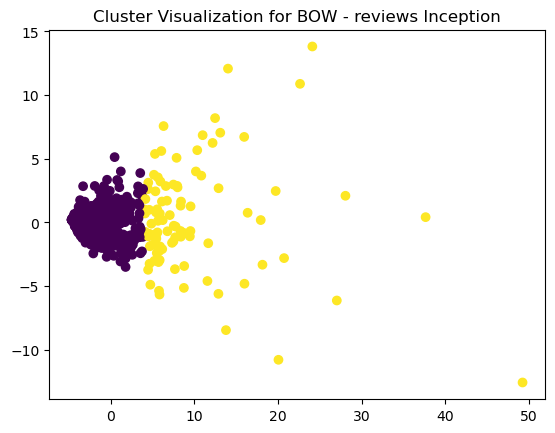

For TF-IDF, the average silhouette_score is : 0.006951471603481083


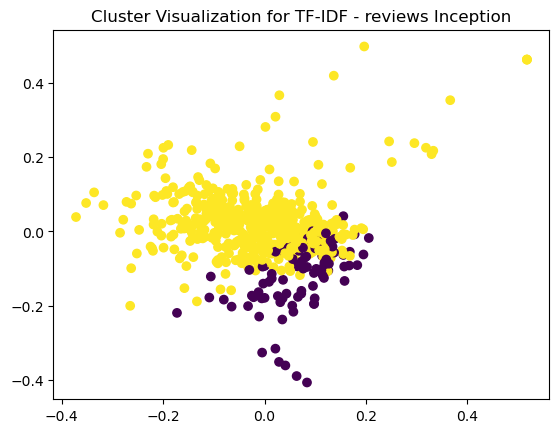

For N-gram, the average silhouette_score is : 0.5539588794509943


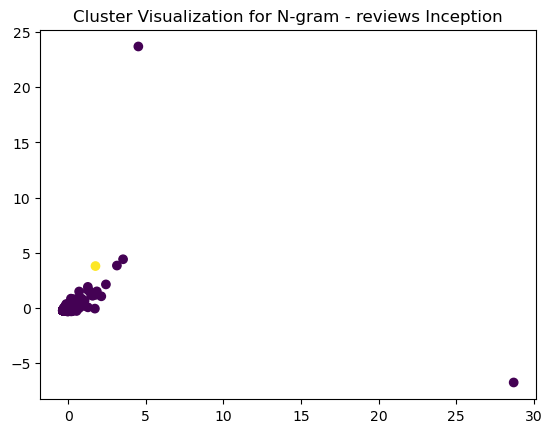

In [104]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def cluster_and_plot_newsgroups(vectors, title):
    # K-means clustering
    kmeans_newsgroups = KMeans(n_clusters=2, random_state=0).fit(vectors)
    # Calcul du coefficient de silhouette
    silhouette_avg = silhouette_score(vectors, kmeans_newsgroups.labels_)
    print(f"For {title}, the average silhouette_score is : {silhouette_avg}")
    
    # PCA for dimensionality reduction
    pca_newsgroups = PCA(n_components=2, svd_solver='arpack')  # Specify svd_solver='arpack'
    reduced_vectors_newsgroups = pca_newsgroups.fit_transform(vectors)
    # Plotting
    plt.figure()
    plt.scatter(reduced_vectors_newsgroups[:,0], reduced_vectors_newsgroups[:,1], c=kmeans_newsgroups.labels_)
    plt.title(f'Cluster Visualization for {title} - reviews Inception')
    plt.show()

# Utilisation de la fonction avec des tableaux NumPy denses
cluster_and_plot_newsgroups(X_bow, "BOW")
cluster_and_plot_newsgroups(X_tfidf, "TF-IDF")
cluster_and_plot_newsgroups(X_ngram, "N-gram")



## Visualisation

### PCA

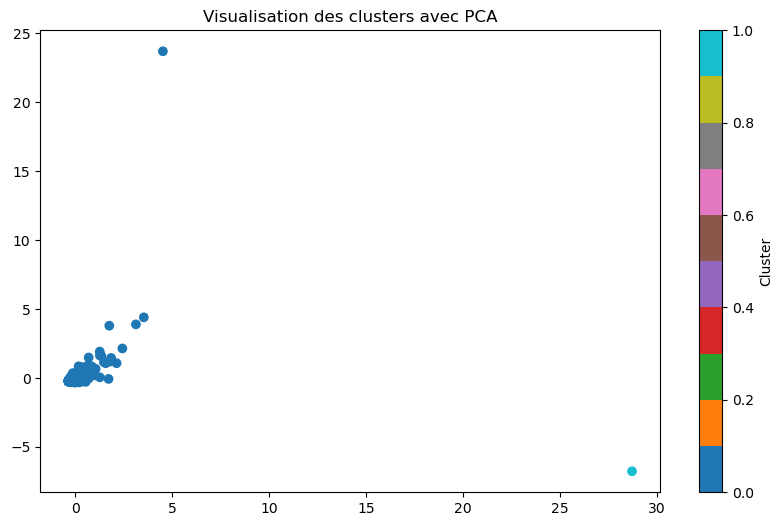

In [103]:
kmeans_bow = KMeans(n_clusters=2,random_state=42,n_init=10)
kmeans_bow.fit(X_ngram)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_ngram.toarray())

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_bow.labels_, cmap='tab10')
plt.colorbar(label='Cluster')
plt.title('Visualisation des clusters avec PCA')
plt.show()



### LDA

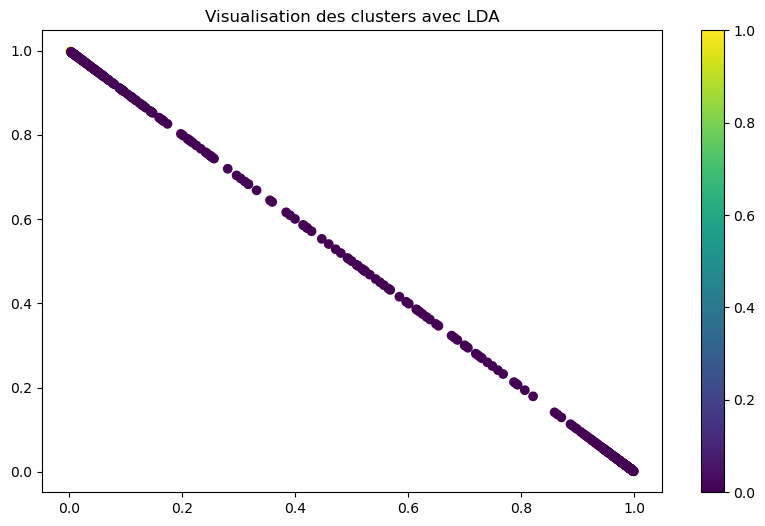

In [105]:
kmeans_bow = KMeans(n_clusters=2,random_state=42,n_init=10)
kmeans_bow.fit(X_ngram)

lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda_result = lda.fit_transform(X_bow)
plt.figure(figsize=(10, 6))
plt.scatter(lda_result[:, 0], lda_result[:, 1], c=kmeans_bow.labels_, cmap='viridis')
plt.title('Visualisation des clusters avec LDA')
plt.colorbar()
plt.show()


## Modelisation

In [160]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test de façon stratifiée
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df_select['target'], test_size=0.2, stratify=df_select['target'], random_state=2)

## Regression logistique

In [161]:
# Construire le modèle de régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [162]:

# Prédire les probabilités pour les ensembles d'entraînement et de test
y_train_pred = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]

In [163]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

# Calculer les valeurs de la courbe ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

# Calculer l'AUC pour les ensembles d'entraînement et de test
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

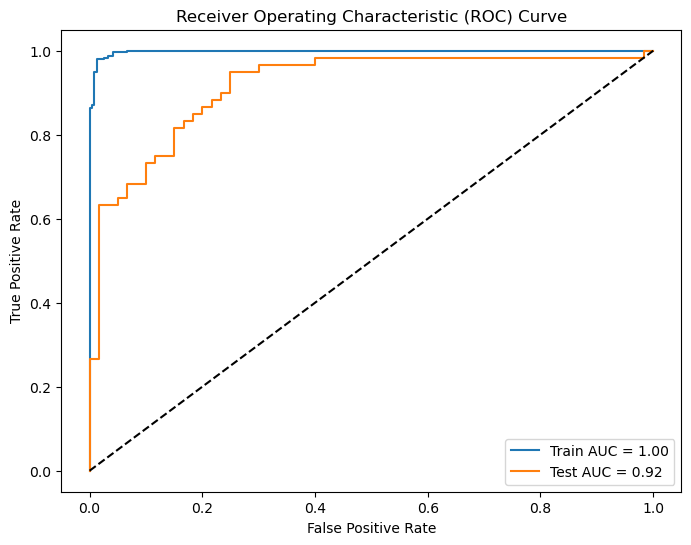

In [164]:
# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label='Train AUC = {:.2f}'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='Test AUC = {:.2f}'.format(auc_test))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [165]:
predict=model.predict(X_test)

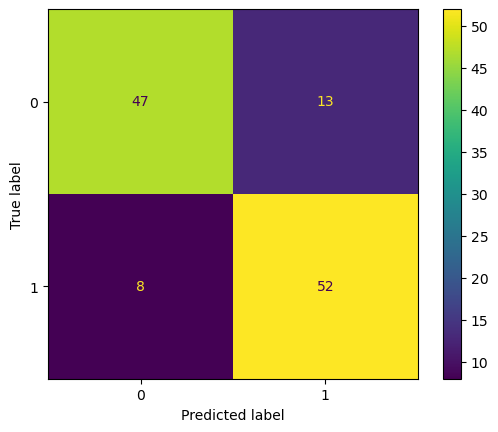

In [166]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(y_test,predict, labels=model.classes_)
display=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
display.plot()
plt.show()

## Calcul des performances sur l'ensemble d'entrainement et test

In [167]:
# Calculer les performances sur les ensembles d'entraînement et de test
train_accuracy = accuracy_score(y_train, model.predict(X_train))
train_precision = precision_score(y_train, model.predict(X_train))
train_recall = recall_score(y_train, model.predict(X_train))
train_f1 = f1_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, model.predict(X_test))
test_precision = precision_score(y_test, model.predict(X_test))
test_recall = recall_score(y_test, model.predict(X_test))
test_f1 = f1_score(y_test, model.predict(X_test))

# Créer un tableau des performances
performance_table = pd.DataFrame({
    'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [train_accuracy, train_precision, train_recall, train_f1],
    'Test': [test_accuracy, test_precision, test_recall, test_f1]
})

print(performance_table)

  Performance     Train      Test
0    Accuracy  0.983333  0.825000
1   Precision  0.987395  0.800000
2      Recall  0.979167  0.866667
3    F1 Score  0.983264  0.832000


## Arbre de decision

Accuracy: 0.65

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.68      0.66        60
           1       0.66      0.62      0.64        60

    accuracy                           0.65       120
   macro avg       0.65      0.65      0.65       120
weighted avg       0.65      0.65      0.65       120


Confusion Matrix:
[[41 19]
 [23 37]]


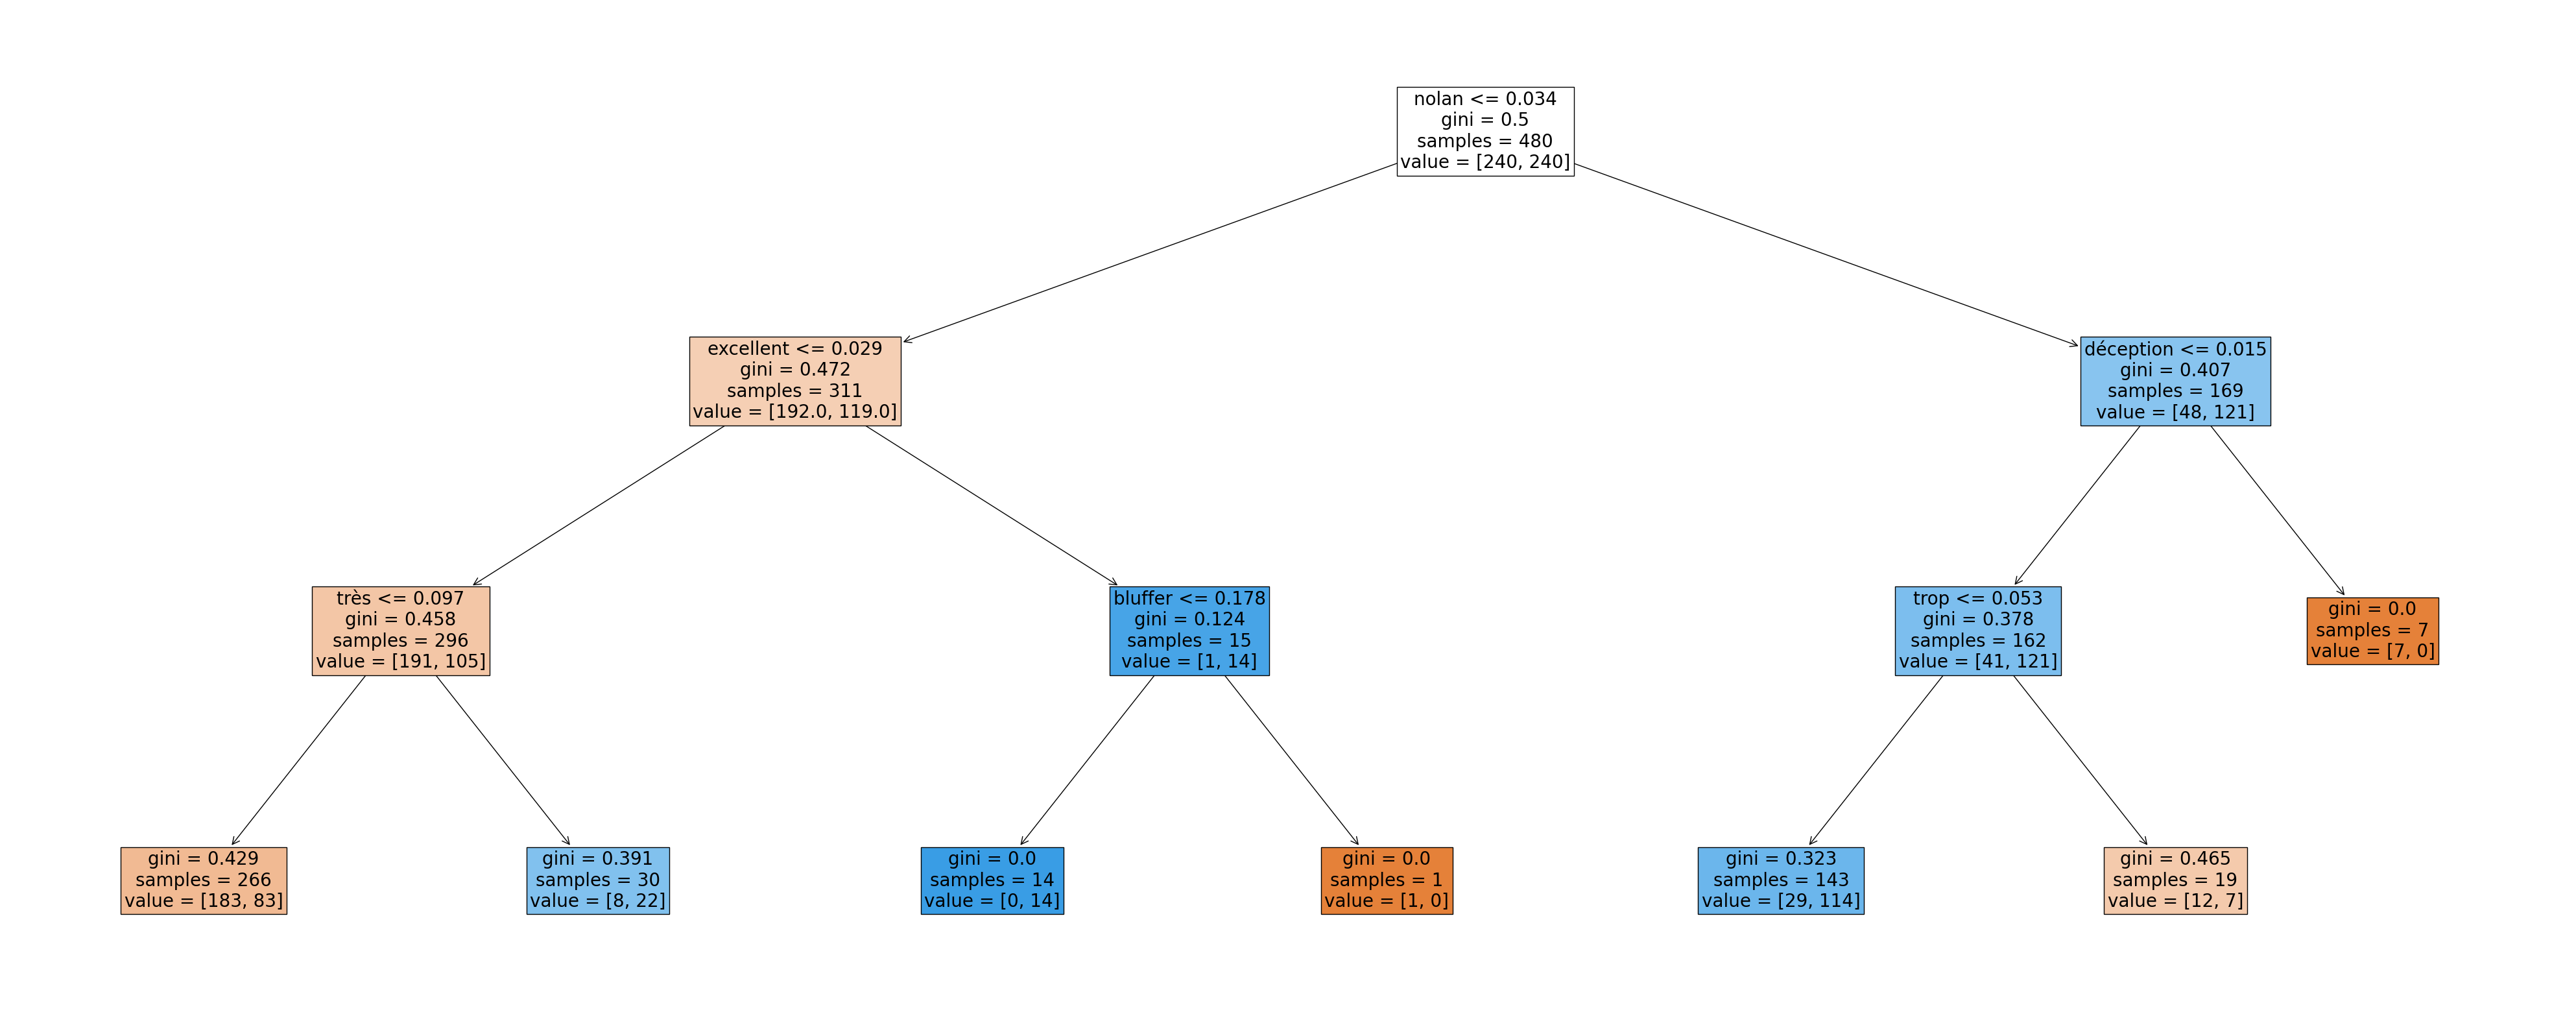

In [178]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree



# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df_select['target'], test_size=0.2, random_state=2, stratify=df_select['target'])
# Création et entraînement de l'arbre de décision
clf = DecisionTreeClassifier(max_depth=3, random_state=2)
clf.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = clf.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Convertir le tableau NumPy en liste
feature_names_list = list(vectorizer_bow.get_feature_names_out())

# Affichage de l'arbre de décision
plt.figure(figsize=(51, 20))
plot_tree(clf, filled=True, feature_names=feature_names_list,fontsize=20)
plt.show()

### save model

In [179]:
import pickle

In [188]:
filename='trained_model_regression_logistique_sav'
pickle.dump(model,open(filename, 'wb'))
pickle.dump(vectorizer_tfidf,open('vectorizer.pkl', 'wb'))

### using the saved model for future predictions

In [181]:
#loading the saved model
loaded_model=pickle.load(open('trained_model_regression_logistique_sav', 'rb'))


In [185]:
X_new = X_test[110].reshape(1, -1)

print(y_test.iloc[110])

prediction=model.predict(X_new)
print(prediction)
if (prediction[0]==0):
    print("Negative review")
else:
    print("Positive review")


1
[1]
Positive review
